In [ ]:
# =====================
#  COMPATIBILITY CHECK & INSTALLATION (Run First!)
# =====================
# Downgrade NumPy and install compatible versions of required packages
# Note that astropy and lightkurve require a numpy version less than 2
!pip install "numpy<2" batman-package astropy lightkurve scikit-learn --upgrade --quiet

# Restart kernel after this cell
import os
os.kill(os.getpid(), 9)


In [4]:
# =====================
# IMPORT LIBRARIES & VERIFY COMPATIBILITY
# =====================
import numpy as np
import batman
import lightkurve as lk
import astropy
import sklearn


print("NumPy version:", np.__version__)
print("Batman version:", batman.__version__)
print("Lightkurve version:", lk.__version__)
print("Astropy version:", astropy.__version__)
print("Scikit-learn version:", sklearn.__version__)

NumPy version: 1.26.4
Batman version: 2.5.1
Lightkurve version: 2.5.0
Astropy version: 7.0.1
Scikit-learn version: 1.6.1


In [125]:
# Import more libraries needed
import pandas as pd
import matplotlib.pyplot as plt
from astropy.timeseries import BoxLeastSquares
from scipy.signal import medfilt, savgol_filter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import time

**NOTEBOOK STRUCTURE:**


1.   Step N-1: Load the LightCurve Data
2.   Step N-2: Clean the Data (outliers, de-trending)
1.   Step N-3: Feature Extraction: Period, Transit Duration,
2.   Step N-4: Baseline Model

*Note that each of these logical steps may entail multiple physical steps. Furthermore, note that Visualizations are interspersed throughout the Notebook.*


**DATASET SOURCE**:
https://exoplanetarchive.ipac.caltech.edu/overview/Kepler-10#planet_Kepler-10-b_collapsible


**CAVEAT: **
Note that this notebook analyzes only 1 Lightcurve, which we know contains evidence of an Exoplanet of known Period and Transit Duration. Thus this Analysis produces only 1 row of data for input into the Base Model. Clearly **this is not enough to execute the Base Model**, but *it serves as proof of concept on correctly identifying the Exoplanet's presence as it transits in front of the star*.

This work will be improved upon to **process many such Lightcurves each from a different dataset**, some with Exoplanets and some without, to create the data which will then be fed into the final Model or ensemble of models.

In [93]:
# =====================
# Step N-1: LOAD TESS/K2/Kepler DATA (via lightkurve)
# =====================
# Example: Load light curve for a known exoplanet
# Step 1: Load Lightcurve (TESS or Kepler)
target_name = "Kepler-10"  # Change this to any Kepler or TESS target
lc = lk.search_lightcurve(target_name, mission="Kepler").download()


df = pd.DataFrame({
    'time': lc.time.value.astype(np.float64),  # convert from Astropy time to standard float
    'flux': lc.flux.value.astype(np.float64)   # same for flux to be on the safe side
})


#df.to_csv('sample_data/kepler_exoplanet_lightcurve.csv')

#lc = lc.normalize().remove_nans()
#lc.plot(title=f"Normalized Lightcurve for {target_name}")

#search_result = lk.search_lightcurve("Kepler-10", mission='Kepler')
#lc = search_result.download()
#lc = lc.normalize().remove_nans().flatten()




/usr/local/lib/python3.11/dist-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 50 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


In [94]:
# =====================
# Step N-2:Clean the Data:  Handle missing values
# =====================

print("\nMissing Values:")
print(df.isna().sum())


Missing Values:
time    0
flux    2
dtype: int64


In [95]:
df = df.dropna()
print("\nRecheck for Missing Values:")
print(df.isna().sum())


Recheck for Missing Values:
time    0
flux    0
dtype: int64


In [96]:
# =====================
# Step N-2:Clean the Data:  Handle Irregular cadence in the dataset
# =====================

def detect_cadence_type(lightcurve, verbose=True):
    """
    Determines whether a Kepler/TESS lightcurve is short- or long-cadence.
    Parameters:
        lightcurve (LightCurve): a lightkurve LightCurve object
        verbose (bool): if True, print summary
    Returns:
        str: 'short cadence', 'long cadence', or 'unknown cadence'
    """
    if lightcurve is None or not hasattr(lightcurve, 'time'):
        raise ValueError("Input must be a valid LightCurve object with a 'time' attribute.")

    # Compute cadence in minutes
    dt_min = np.diff(lightcurve.time.value) * 24 * 60
    median_cadence = np.median(dt_min)


    if verbose:
        print(f"Minimum cadence     : {np.min(dt_min):.4f} minutes")
        print(f"1st quartile cadence: {np.quantile(dt_min, 0.25):.4f} minutes")
        print(f"Median cadence      : {median_cadence:.4f} minutes")
        print(f"3rd quartile cadence: {np.quantile(dt_min, 0.75):.4f} minutes")
        print(f"99th quantile cadence: {np.quantile(dt_min, 0.99):.4f} minutes")
        print(f"Maximum cadence     : {np.max(dt_min):.4f} minutes")
        print("----------------------------------")

    # Classify cadence
    if 0.9 < median_cadence < 1.5:
        return "Short cadence"
    elif 28 < median_cadence < 31:
        return "Long cadence"
    else:
        return "Unknown cadence"

print(detect_cadence_type(lc, True))

Minimum cadence     : 0.9805 minutes
1st quartile cadence: 0.9808 minutes
Median cadence      : 0.9808 minutes
3rd quartile cadence: 0.9809 minutes
99th quantile cadence: 0.9809 minutes
Maximum cadence     : 530.6158 minutes
----------------------------------
Short cadence


***Takeaway:*** The above analysis indicates that the cadence (time interval between successive observations) is **quite centrally distributed, clustered around a value of close to 0.9808 minutes (short cadence)**. However there is evidence of some observations which are anomalously spaced (max cadence of approx 530 minutes).  This warrants further investigation on **the extent of low frequency observations** in the dataset.

In [97]:
# Investigate Further on Cadence............
# Convert lightkurve.lightcurve object to a pandas dataframe


# Compute  Cadence from the dataset
df = df.sort_values('time').reset_index(drop=True) #First sort by Time ascending
df['dt_min'] = df['time'].diff() * 24 * 60  # Convert days to minutes

# Summary stats for cadence
print("Cadence (time difference between observations):")
print(df['dt_min'].describe())

# Count how many cadence values are greater than 1 minute
num_high_cadence = (df['dt_min'] >  df['dt_min'].median() * 1.5).sum()
print(f"Number of observations with dt_min > 1.5 X median Cadence: {num_high_cadence}")
df[df['dt_min']> df['dt_min'].median() * 1.5]


Cadence (time difference between observations):
count    43360.000000
mean         0.995490
std          2.549052
min          0.980486
25%          0.980778
50%          0.980784
75%          0.980920
max        530.615789
Name: dt_min, dtype: float64
Number of observations with dt_min > 1.5 X median Cadence: 11


,time,flux,dt_min
3880,202.975014,556961.7500,12.750522
8248,205.958327,556826.5625,12.750647
12616,208.941635,557017.3750,12.750627
16984,211.924939,556930.1250,12.750753
21352,214.907556,556899.1875,11.769808
25721,217.891532,557025.5625,12.750570
30089,220.874822,556909.2500,12.750408
33929,223.858108,557142.0000,530.615789
38223,226.784176,557170.1250,2.942471
38295,226.841390,556940.3125,12.750514


Takeaway: A preprocessing/data cleaning step is needed to remove the anomalously spaced observations.

In [98]:
# Preprocessing Step: remove anomalously spaced observations
threshold = df['dt_min'].median() * 1.5
df['irregular_dt_min'] = df['dt_min'] > threshold
df = df[~df['irregular_dt_min'].fillna(False)]

# Preview the dataset
print("Head of Data:")
print(df.head())
print("\nData Summary:")
print(df.describe())

Head of Data:
         time         flux    dt_min  irregular_dt_min
0  200.324085  556960.0000       NaN             False
1  200.324766  557085.8750  0.980788             False
2  200.325447  557031.8750  0.980788             False
3  200.326128  556844.4375  0.980789             False
4  200.326809  556807.8750  0.980788             False

Data Summary:
               time           flux        dt_min
count  43350.000000   43350.000000  43349.000000
mean     215.205927  556935.994242      0.980810
std        8.656027     152.195779      0.000087
min      200.324085  554957.125000      0.980486
25%      207.723281  556847.312500      0.980778
50%      215.130622  556935.812500      0.980784
75%      222.529763  557025.500000      0.980920
max      230.299402  564278.937500      0.980933


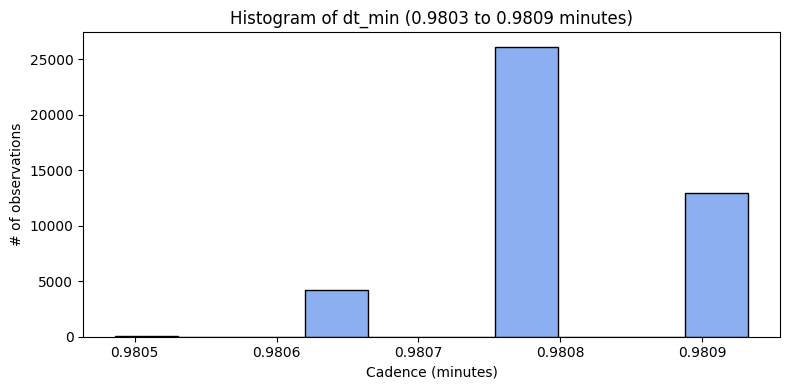

In [99]:
# =====================
# Histogram of dt_min in range 0.9803–0.9809
# =====================
plt.figure(figsize=(8, 4))
mask = (df['dt_min'] >= 0.9803) & (df['dt_min'] <= 0.99)
sns.histplot(df.loc[mask, 'dt_min'], bins=10, color='cornflowerblue', edgecolor='black')
plt.title("Histogram of dt_min (0.9803 to 0.9809 minutes)")
plt.xlabel("Cadence (minutes)")
plt.ylabel("# of observations")
plt.tight_layout()
plt.show()


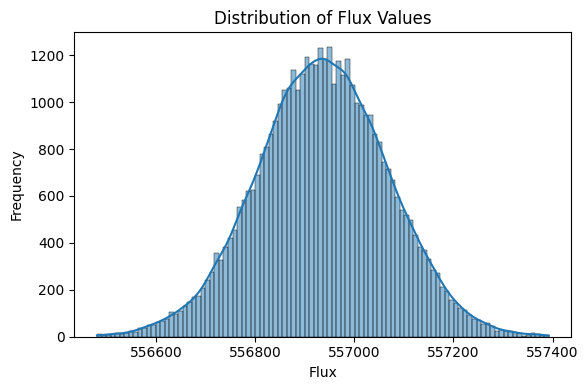

In [112]:
# =====================
# Step N-2:Clean the Data:  Explore the distribution of  FLUX Values to look for outliers
# =====================
# Histogram of flux values BEFORE  De-Trending
plt.figure(figsize=(6, 4))
sns.histplot(df['flux'], bins=100, kde=True)
plt.title("Distribution of Flux Values")
plt.xlabel("Flux")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


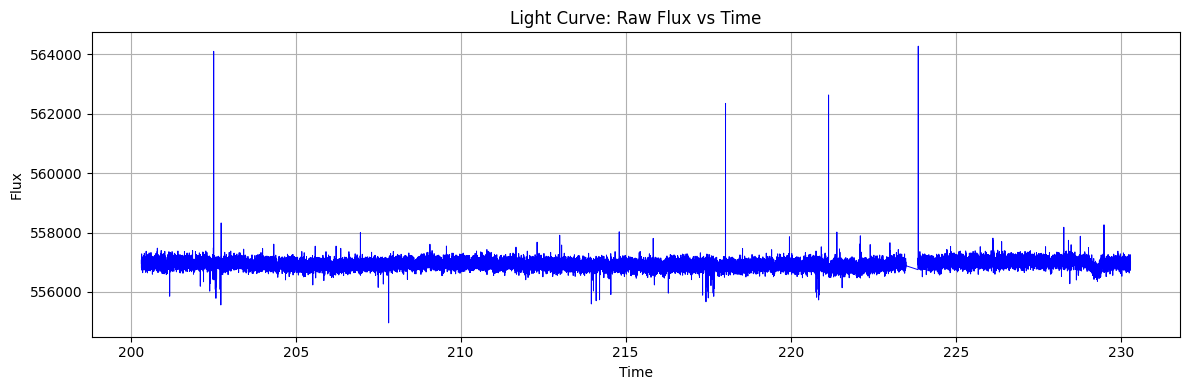

In [100]:
# Raw flux over time
plt.figure(figsize=(12, 4))
plt.plot(df['time'], df['flux'], color='blue', linewidth=0.7)
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title("Light Curve: Raw Flux vs Time")
plt.grid(True)
plt.tight_layout()
plt.show()

The plot of Raw Flux versus time shows the presence of outlier flux values which infrequently appear across time. Investigate further to **identify and remove outlier flux values**.

In [103]:
# =====================
# Step N-2:Clean the Data:  Identify and Remove Outlier FLUX Values
# =====================

print("Analyze distribution of Flux values")
print("-----------------------------------")
print(f"Minimum Flux     : {np.min(df['flux']):.4f} photoelectrons/second")
print(f"1st quartile Flux: {np.quantile(df['flux'], 0.25):.4f} photoelectrons/second")
print(f"Median Flux      : {np.median(df['flux']):.4f} minutes")
print(f"3rd quartile Flux: {np.quantile(df['flux'], 0.75):.4f} photoelectrons/second")
print(f"99th quantile Flux: {np.quantile(df['flux'], 0.99):.4f} photoelectrons/second")
print(f"Maximum Flux     : {np.max(df['flux']):.4f} minutes")
# Count how many cadence values are greater than 1 minute
flux_mean = np.mean(df['flux'])
flux_std = np.std(df['flux'])
flux_lower_bound = flux_mean - 3 * flux_std
flux_upper_bound = flux_mean + 3 * flux_std
num_high_flux = (df['flux'] >  flux_upper_bound).sum()
print(f"Number of observations with flux > mean + 3 sigma : {num_high_flux}")
num_low_flux = (df['flux'] <  flux_lower_bound).sum()
print(f"Number of observations with flux > mean + 3 sigma : {num_low_flux}")


Analyze distribution of Flux values
-----------------------------------
Minimum Flux     : 554957.1250 photoelectrons/second
1st quartile Flux: 556847.3125 photoelectrons/second
Median Flux      : 556935.8125 minutes
3rd quartile Flux: 557025.5000 photoelectrons/second
99th quantile Flux: 557252.8444 photoelectrons/second
Maximum Flux     : 564278.9375 minutes
Number of observations with flux > mean + 3 sigma : 51
Number of observations with flux > mean + 3 sigma : 71


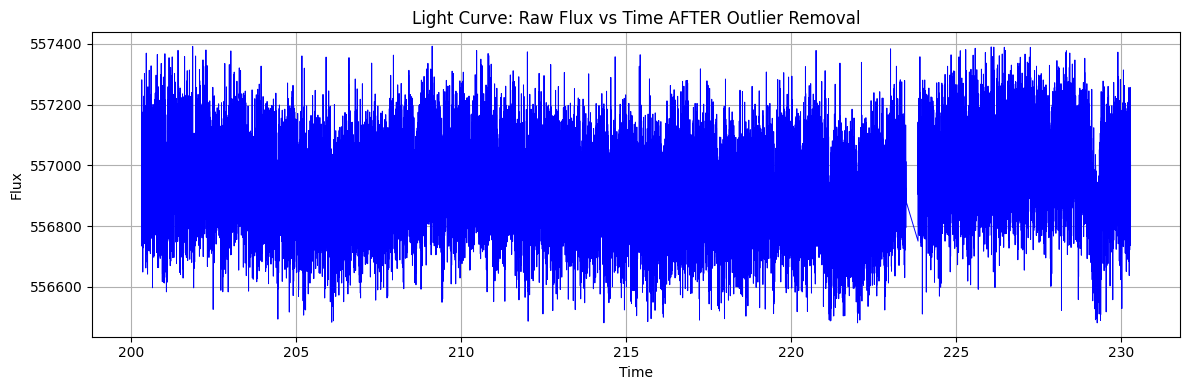

In [104]:
# =====================
# Step N-2:Clean the Data: Remove Outlier FLUX Values
# =====================

df = df[(df['flux'] >= flux_lower_bound) & (df['flux'] <= flux_upper_bound)]


plt.figure(figsize=(12, 4))
plt.plot(df['time'], df['flux'], color='blue', linewidth=0.7)
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title("Light Curve: Raw Flux vs Time AFTER Outlier Removal")
plt.grid(True)
plt.tight_layout()
plt.show()

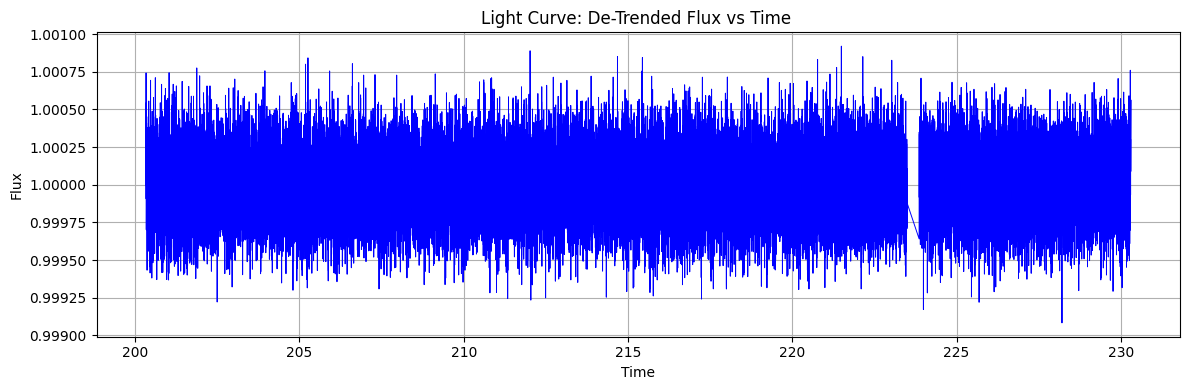

In [105]:
# =====================
# Step N-2:Clean the Data:  Perform De-Trending
# =====================

from scipy.signal import medfilt
df['flux_detrended'] = df['flux'] / medfilt(df['flux'], kernel_size=101)


plt.figure(figsize=(12, 4))
plt.plot(df['time'], df['flux_detrended'], color='blue', linewidth=0.7)
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title("Light Curve: De-Trended Flux vs Time ")
plt.grid(True)
plt.tight_layout()
plt.show()

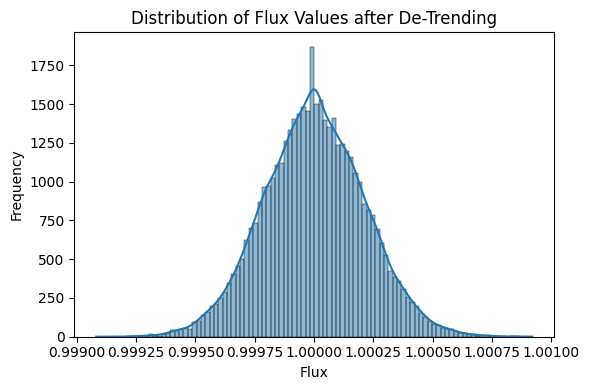

In [111]:
# Histogram of flux values AFTER De-Trending
plt.figure(figsize=(6, 4))
sns.histplot(df['flux_detrended'], bins=100, kde=True)
plt.title("Distribution of Flux Values after De-Trending")
plt.xlabel("Flux")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [130]:
# =====================
# Step N-3: Feature Engineering: Determine PERIOD and TRANSIT DURATION of Exoplanet.
# =====================
#
#--------------------------------------------------------------------------
# Prepare variables
Time = df['time'].values
flux = df['flux_detrended'].values

# Define BLS period grid (e.g., search between 0.5 and 30 days)
start_time = time.time()
print("Beginning BLS..............")
bls = BoxLeastSquares(Time, flux)
end_time = time.time()
print("BLS Executed Successfully: Elapsed Time: ", end_time - start_time)

periods = np.linspace(0.5, 1.1, 10000)  # fine grid for precision

# Transit duration grid (fixed fraction of period)
duration = 0.1 * periods
print("Minimum Period: "  , np.min(periods))
print("Maximum Period: "  , np.max(periods))
print("Minimum Duration: ", np.min(duration))
print("Maximum Duration: ", np.max(duration))

# Run BLS search
start_time = time.time()
print("Beginning BLS Power..............")
results = bls.power(periods, duration)
end_time = time.time()
print("BLS Power Successfully: Elapsed Time: ", end_time - start_time)


# Find best period
best_period = results.period[np.argmax(results.power)]
best_t0 = results.transit_time[np.argmax(results.power)]
best_duration = results.duration[np.argmax(results.power)]

print(f"Best period: {best_period:.5f} days")
print(f"Transit time (t0): {best_t0:.5f}")
print(f"Transit duration: {best_duration:.5f} days")

Beginning BLS..............
BLS Executed Successfully: Elapsed Time:  0.0002899169921875
Minimum Period:  0.5
Maximum Period:  1.1
Minimum Duration:  0.05
Maximum Duration:  0.11000000000000001
Beginning BLS Power..............
BLS Power Successfully: Elapsed Time:  140.5762059688568
Best period: 0.83747 days
Transit time (t0): 201.08409
Transit duration: 0.07000 days


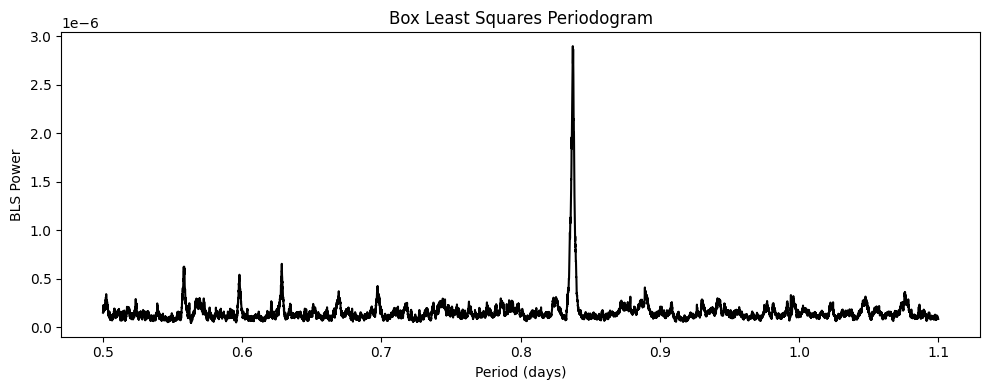

In [132]:

# Plot BLS power spectrum
plt.figure(figsize=(10, 4))
plt.plot(results.period, results.power, color='black')
plt.xlabel("Period (days)")
plt.ylabel("BLS Power")
plt.title("Box Least Squares Periodogram")
plt.tight_layout()
plt.show()

**Takeaway: Successful identification of Exoplanet Kepler 10-b**. The Result obtained above,  of **Best Period = 0.83747 days** and **Transit Duration of 0.0700 days** quite closely matches the value published by  https://exoplanetarchive.ipac.caltech.edu/overview/Kepler-10#planet_Kepler-10-b_collapsible. Specifically the values obtained by the Python Notebook are very close the published values of the 1st Exoplanet of the Kepler-10 Star System called **Kepler-10b** with an **Orbital Period of 0.8374907 days**, and a **Transit Duration of 1.81 hours i.e., 0.07541667 days.**

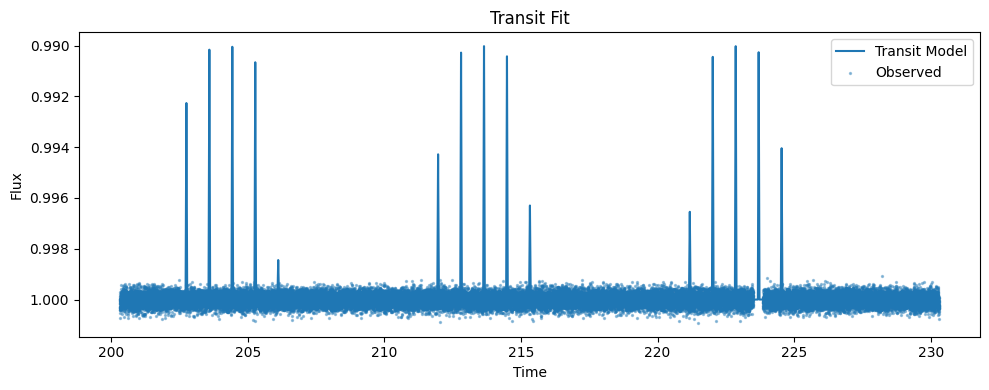

In [136]:
# Transit Fitting with Batman
params = batman.TransitParams()
params.t0 = best_t0
params.per = best_period
params.rp = 0.1
params.a = 15
params.inc = 87
params.ecc = 0
params.w = 90
params.u = [0.1, 0.3]
params.limb_dark = "quadratic"


model_time = np.linspace(min(Time), max(Time), 1000)
m = batman.TransitModel(params, model_time)
model_flux = m.light_curve(params)


plt.figure(figsize=(10, 4))
plt.plot(model_time, model_flux, label="Transit Model")
plt.scatter(Time, flux, s=2, alpha=0.4, label="Observed")
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title("Transit Fit")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [139]:

# =====================
# Step N-3. FEATURE EXTRACTION FOR ML
# =====================
features = pd.DataFrame({
    'period': [best_period],
    'duration': [best_duration],
    'depth': [np.min(model_flux)],
    'bls_power': [np.max(results.power)]
})
labels = [1]  # 1 = transit, 0 = non-transit (for demonstration)
features.head()

,period,duration,depth,bls_power
0,0.837474,0.07,0.990023,0.000003


In [ ]:

# =====================
# Step N-4. ML CLASSIFICATION (Random Forest)
# =====================
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

